# Python imports

In [1]:
from n2v.models import N2VConfig, N2V
from skimage import io
import numpy as np
import random
import tensorflow as tf
from tqdm.notebook import tqdm
from csbdeep.utils import plot_history, Path
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
from tifffile import imread, TiffFile
import random

import urllib
import os
import zipfile

Using TensorFlow backend.


Where the data is

In [2]:
base_dir = r'Z:\200406 starchaea biorxiv\noise2void\membrane'
base_dir_raw = r'Z:\200406 starchaea biorxiv\noise2void\membrane'

base_path = Path(base_dir)
#raw_files = sorted(Path(base_path/r'raw data').rglob('*.tif'))
#print(f'There are {len(raw_files)} files to analyse!')

#n2v_train_dir = base_path/f'n2v train'
#n2v_train_dir.mkdir(exist_ok=True)

#n2v_val_dir = base_path/f'n2v validation'
#n2v_val_dir.mkdir(exist_ok=True)

##n2v_model_dir = base_path/f'models'
##n2v_model_dir.mkdir(exist_ok=True)

Get image information

ims = []

for file in raw_files:
    T = imread(str(file))
    print(f'T has shape {T.shape}')
    ims.append(T)

Create training and validation patches - assume only one channel for now

In [3]:
datagen = N2V_DataGenerator()
imgs = datagen.load_imgs_from_directory(directory=base_dir_raw)
print(imgs[0].shape,imgs[1].shape)

n_imgs = len(imgs)

# We will use even-indexed images to extract training patches and store them in 'X'
X = datagen.generate_patches_from_list(imgs[::8], shape=(96,96))

# We will use the second image to extract validation patches.
X_val = datagen.generate_patches_from_list(imgs[1::8], shape=(96,96))

print(f'n training patches is {len(X)}')
print(f'n validation patches is {len(X_val)}')

(1, 1200, 1200, 1) (1, 1200, 1200, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
Generated patches: (1152, 96, 96, 1)
n training patches is 9216
n validation patches is 9216


patch_size = 64
n_patch_train = 500
n_patch_val = 50

X = []
X_val = []

for n in range(n_patch_train):
    im = random.choice(ims)
    frame = random.choice(range(im.shape[0]))
    x_start = random.choice(range(im.shape[1]-patch_size))
    y_start = random.choice(range(im.shape[2]-patch_size))
    X.append(im[frame][x_start:x_start+patch_size, y_start:y_start+patch_size])
    
for n in range(n_patch_val):
    im = random.choice(ims)
    frame = random.choice(range(im.shape[0]))
    x_start = random.choice(range(im.shape[1]-patch_size))
    y_start = random.choice(range(im.shape[2]-patch_size))
    X_val.append(im[frame][x_start:x_start+patch_size, y_start:y_start+patch_size])
    
X = np.array(X)
X_val = np.array(X_val)

# add channel dimension for n2v
X = X[..., np.newaxis]
X_val = X_val[..., np.newaxis]

Preview training and validation

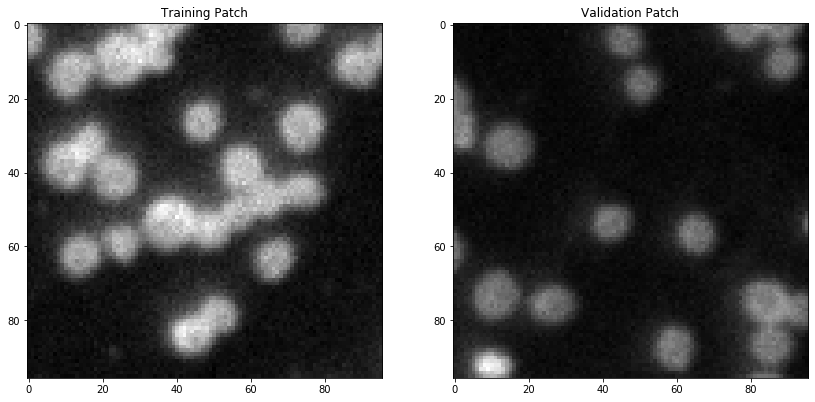

In [4]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='gray')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='gray')
plt.title('Validation Patch');

Prepare for n2v

In [6]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128), train_epochs=200, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['300.38614'],
 'stds': ['180.46838'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 96,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 200,
 'train_steps_per_epoch': 72,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'probabilistic': False}

In [7]:
# a name used to identify the model
model_name = 'starchaea_membrane'
# We are now creating our network model.
model = N2V(config, model_name, basedir='models')
#model.prepare_for_training(metrics=())

C:\Users\SC\Anaconda3\lib\site-packages\n2v\models\n2v_standard.py:409: UserWarning: output path for model already exists, files may be overwritten: C:\Users\SC\uwecode\archaea_tools\models\starchaea_membrane
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
W0415 18:15:21.067788 11776 module_wrapper.py:139] From C:\Users\SC\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0415 18:15:21.080604 11776 module_wrapper.py:139] From C:\Users\SC\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0415 18:15:21.086783 11776 module_wrapper.py:139] From C:\Users\SC\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0

Train model

In [ ]:
history = model.train(X, X_val)

Preparing validation data: 100%|█████████████████████████████████████| 9216/9216 [00:10<00:00, 877.14it/s]


Epoch 1/200
72/72 [==============================] - 2429s 34s/step - loss: 0.1467 - val_loss: 0.0911
Epoch 2/200
72/72 [==============================] - 2433s 34s/step - loss: 0.0362 - val_loss: 0.0947
Epoch 3/200
72/72 [==============================] - 2443s 34s/step - loss: 0.0476 - val_loss: 0.0529
Epoch 4/200
72/72 [==============================] - 2435s 34s/step - loss: 0.0547 - val_loss: 0.0647
Epoch 5/200
72/72 [==============================] - 2438s 34s/step - loss: 0.0371 - val_loss: 0.0206
Epoch 6/200
72/72 [==============================] - 2434s 34s/step - loss: 0.0193 - val_loss: 0.0178
Epoch 7/200
72/72 [==============================] - 2434s 34s/step - loss: 0.0329 - val_loss: 0.0176
Epoch 8/200
72/72 [==============================] - 2438s 34s/step - loss: 0.0194 - val_loss: 0.0124
Epoch 9/200
72/72 [==============================] - 2437s 34s/step - loss: 0.0147 - val_loss: 0.0121
Epoch 10/200
72/72 [==============================] - 2433s 34s/step - loss: 0.013

72/72 [==============================] - 2442s 34s/step - loss: 0.0096 - val_loss: 0.0086
Epoch 80/200
72/72 [==============================] - 2442s 34s/step - loss: 0.0095 - val_loss: 0.0088
Epoch 81/200
72/72 [==============================] - 2442s 34s/step - loss: 0.0103 - val_loss: 0.0091
Epoch 82/200
72/72 [==============================] - 2447s 34s/step - loss: 0.0105 - val_loss: 0.0107
Epoch 83/200
72/72 [==============================] - 2443s 34s/step - loss: 0.0103 - val_loss: 0.0091
Epoch 84/200
72/72 [==============================] - 2442s 34s/step - loss: 0.0094 - val_loss: 0.0088
Epoch 85/200
72/72 [==============================] - 2443s 34s/step - loss: 0.0092 - val_loss: 0.0089
Epoch 86/200
72/72 [==============================] - 2450s 34s/step - loss: 0.0116 - val_loss: 0.0105

Epoch 00086: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 87/200
72/72 [==============================] - 2443s 34s/step - loss: 0.0098 - val_loss: 0.0089
Epoch

In [8]:
denoised = []
for img in tqdm(imgs):
    denoised.append(model.predict(img[0,...,0].astype(np.float32),'YX'))

In [9]:
io.imsave('membrane_denoised.tif', np.asarray(denoised))

In [ ]:
base_dir_C2 = r'X:\GautamDey\2020\Fast Nup imaging\separate for denoising\C2'
base_path_C2= Path(base_dir_C2)
raw_files_C2 = sorted(Path(base_path_C2/r'raw data').rglob('*.tif'))

ims_2= []

for file in raw_files_C2:
    T2 = imread(str(file))
    print(f'T2 has shape {T2.shape}')
    ims_2.append(T2)

In [ ]:
denoised_2 = []
for frame in tqdm(T2):
    denoised_2.append(model.predict(frame.astype(np.float32),'YX'))


In [ ]:
denoised_2 = denoised[120:]

In [ ]:
io.imsave('denoised_c2.tif', np.asarray(denoised_2))

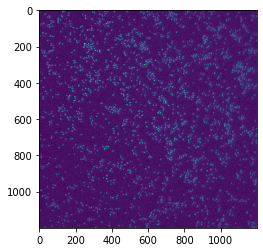

In [10]:
plt.imshow(imgs[0][0,...,0])